# Preprocessing

데이터 전처리

데이터를 모델의 입력으로 넣기 전에 모델의 특성에 맞게 입력 값을 조정해야 할 필요가 있습니다. 

Feature 들 간의 값 범위가 상관 없는 모델도 있지만, 대부분의 모델들은 Feature 들간의 값 범위를 맞추거나 Feature 내에 이상치를 조정해주는 것이 모델의 학습 시간과 성능을 높이는데 도움을 주게 됩니다. 

하지만, Feature 들의 분포를 변형하는 전처리는 Feature의 특성에 변형을 가져오기 때문에 모델에 따라 성능이 낮아지는 현상이 나타날 수도 있기 때문에 신중해야 합니다.   

* https://scikit-learn.org/stable/modules/preprocessing.html
* https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

캘리포니아 주거 데이터 셋의 Feature 0 (블록 단위 평균 소득)과 Feature 5 (평균 주택 점유율)는 매우 다른 범위이며 매우 큰 이상치를 포함합니다. 

이 두 가지 Feature는 데이터를 시각화하는 데 어려움을 야기하며 더 중요한 것은 많은 모델의 예측 성능을 저하시킬 수 있다는 것입니다. 

스케일되지 않은 데이터는 또한 그래디언트 기반 학습시에 수렴을 지연 시키거나 방해 할 수 있습니다.

## Standardization, or mean removal and variance scaling

In [2]:
# Author:  Raghav RV <rvraghav93@gmail.com>
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
#          Thomas Unterthiner
# License: BSD 3 clause

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.datasets import fetch_california_housing

dataset = fetch_california_housing()
X_full, y_full = dataset.data, dataset.target
feature_names = dataset.feature_names

feature_mapping = {
    "MedInc": "Median income in block",
    "HousAge": "Median house age in block",
    "AveRooms": "Average number of rooms",
    "AveBedrms": "Average number of bedrooms",
    "Population": "Block population",
    "AveOccup": "Average house occupancy",
    "Latitude": "House block latitude",
    "Longitude": "House block longitude",
}

# Take only 2 features to make visualization easier
# Feature MedInc has a long tail distribution.
# Feature AveOccup has a few but very large outliers.
features = ["MedInc", "AveOccup"]
features_idx = [feature_names.index(feature) for feature in features]
X = X_full[:, features_idx]
distributions = [
    ("Unscaled data", X),
    ("Data after standard scaling", StandardScaler().fit_transform(X)),
    ("Data after min-max scaling", MinMaxScaler().fit_transform(X)),
    ("Data after max-abs scaling", MaxAbsScaler().fit_transform(X)),
    (
        "Data after robust scaling",
        RobustScaler(quantile_range=(25, 75)).fit_transform(X),
    ),
    (
        "Data after power transformation (Yeo-Johnson)",
        PowerTransformer(method="yeo-johnson").fit_transform(X),
    ),
    (
        "Data after power transformation (Box-Cox)",
        PowerTransformer(method="box-cox").fit_transform(X),
    ),
    (
        "Data after quantile transformation (uniform pdf)",
        QuantileTransformer(output_distribution="uniform").fit_transform(X),
    ),
    (
        "Data after quantile transformation (gaussian pdf)",
        QuantileTransformer(output_distribution="normal").fit_transform(X),
    ),
    ("Data after sample-wise L2 normalizing", Normalizer().fit_transform(X)),
]

# scale the output between 0 and 1 for the colorbar
y = minmax_scale(y_full)

# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, "plasma_r", cm.hot_r)


def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return (
        (ax_scatter, ax_histy, ax_histx),
        (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
        ax_colorbar,
    )


def plot_distribution(axes, X, y, hist_nbins=50, title="", x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker="o", s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(
        X[:, 1], bins=hist_nbins, orientation="horizontal", color="grey", ec="grey"
    )
    hist_X1.axis("off")

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(
        X[:, 0], bins=hist_nbins, orientation="vertical", color="grey", ec="grey"
    )
    hist_X0.axis("off")

def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(
        axarr[0],
        X,
        y,
        hist_nbins=200,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Full data",
    )

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) & np.all(
        X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1
    )
    plot_distribution(
        axarr[1],
        X[non_outliers_mask],
        y[non_outliers_mask],
        hist_nbins=50,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Zoom-in",
    )

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(
        ax_colorbar,
        cmap=cmap,
        norm=norm,
        orientation="vertical",
        label="Color mapping for values of y",
    )

**Orginal Data**

전체 데이터는 중앙 소득은 [0, 10], 평균 주택 점유율는 [0, 6] 범위 값을 가지고, 일부 이상치(일부 블록에는 평균 주택 점유율이 1200임)를 포함하고 있습니다.

왼쪽 그림은 전체 데이터 세트를 나타낸 것이고, 오른쪽 그림은 이상치가 없는 부분을 확대하여 나타낸 것입니다. 

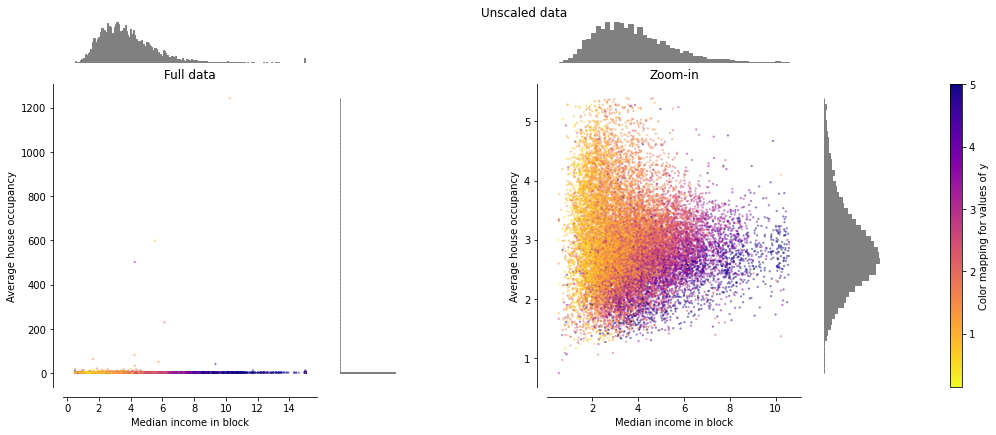

In [3]:
make_plot(0)

### StandardScaler 

StandardScaler는 Mean을 제거하고 Unit Variance로 데이터를 스케일링합니다. 

$
\frac{x - \mu}{\sigma}
$

데이터가 정규 분포를 따른다는 가정하에 일반적으로 데이터에 StandardScaler를 적용하는 경우가 많습니다.

데이터가 심하게 정규 분포에서 벗어날 경우 제대로 동작하지 않을 수 있습니다. 이상치가 존재할 경우도 이는 평균과 표준 편차에 영향을 주기 때문에 그림과 같이 변환된 Feature의 범위에 영향을 미치게 됩니다.

특히 각 Feature의 이상치는 다른 범위를 가지므로 각 Feature의 변환 된 데이터의 분포는 매우 다르게 나타나게 됩니다. 

In [4]:
from sklearn import preprocessing
import numpy as np

X_train = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
print(f"scaler\nmean: {scaler.mean_}, scale: {scaler.scale_}")

X_scaled = scaler.transform(X_train)
print(f"X_scaled\n{X_scaled}")

scaler
mean: [1.         0.         0.33333333], scale: [0.81649658 0.81649658 1.24721913]
X_scaled
[[ 0.         -1.22474487  1.33630621]
 [ 1.22474487  0.         -0.26726124]
 [-1.22474487  1.22474487 -1.06904497]]


예제 데이터셋을 변형해 보면, 대부분의 데이터는 변형 된 중앙 소득 Feature의 [-2, 4] 범위에 속하지만 평균 주택 점유율 Feature는 변환 된 세대수에 대해 더 작은 [-0.2, 0.2] 범위로 변형됩니다. 

따라서, 이상치가 있는 경우 균형 잡힌 범위로 Feature의 변환을 보장할 수 없게 됩니다.

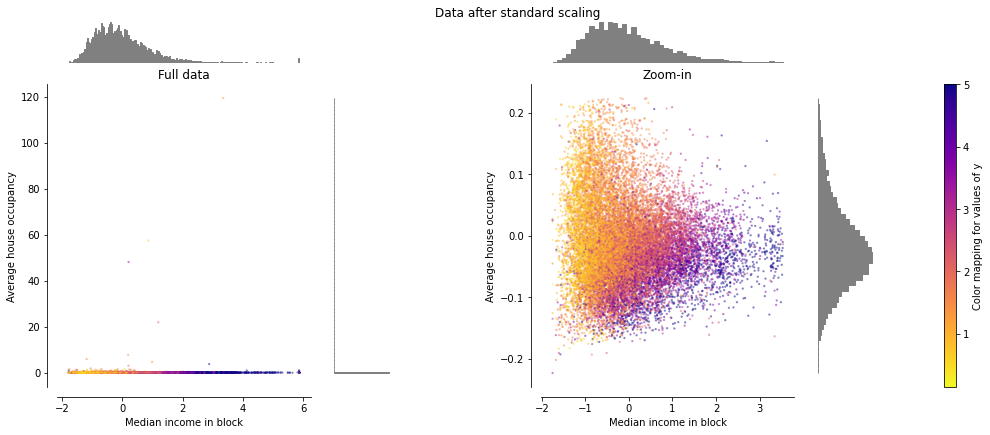

In [5]:
# StandardScaler().fit_transform(X)
make_plot(1)

### MinMaxScaler 

Feature들 간의 변환 범위를 통일하기 위해서 자주 사용됩니다. 지정된 Min, Max 범위로 아래 공식을 통해 계산됩니다.

```python
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [6]:
X_train = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])

scaler = preprocessing.MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
print(f"scaler scale: {scaler.scale_}, min: {scaler.min_}")
print(f"X_train_minmax\n{X_train_minmax}")

scaler = preprocessing.MinMaxScaler(feature_range=(0, 10))
X_train_minmax = scaler.fit_transform(X_train)
print(f"scaler scale: {scaler.scale_}, min: {scaler.min_}")
print(f"X_train_minmax\n{X_train_minmax}")

scaler scale: [0.5        0.5        0.33333333], min: [0.         0.5        0.33333333]
X_train_minmax
[[0.5        0.         1.        ]
 [1.         0.5        0.33333333]
 [0.         1.         0.        ]]
scaler scale: [5.         5.         3.33333333], min: [0.         5.         3.33333333]
X_train_minmax
[[ 5.          0.         10.        ]
 [10.          5.          3.33333333]
 [ 0.         10.          0.        ]]



MinMaxScaler의 기본 변환 범위는 [0, 1]로 모든 Feature가 [0, 1] 범위로 변현된 것을 볼 수 있습니다. 그러나 이상치가 포함된 세대 수의 경우는 [0, 0.005]로 매우 좁은 범위로 변형됩니다. 

StandardScaler와 마찬가지로 MinMaxScaler는 이상치의 존재에 매우 민감합니다.

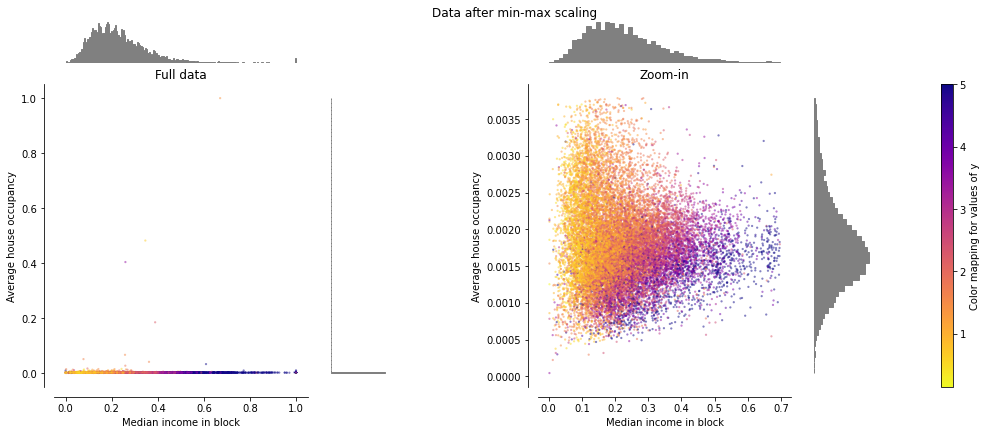

In [7]:
# MinMaxScaler().fit_transform(X))
make_plot(2)

### MaxAbsScaler 

MaxAbsScaler는 절대 값이 범위 [0, 1]에 위치하도록 변형합니다. 

하지만, MinMaxScaler와 유사하게 동작하기 때문에 이상치에 민감한 결과를 보입니다.

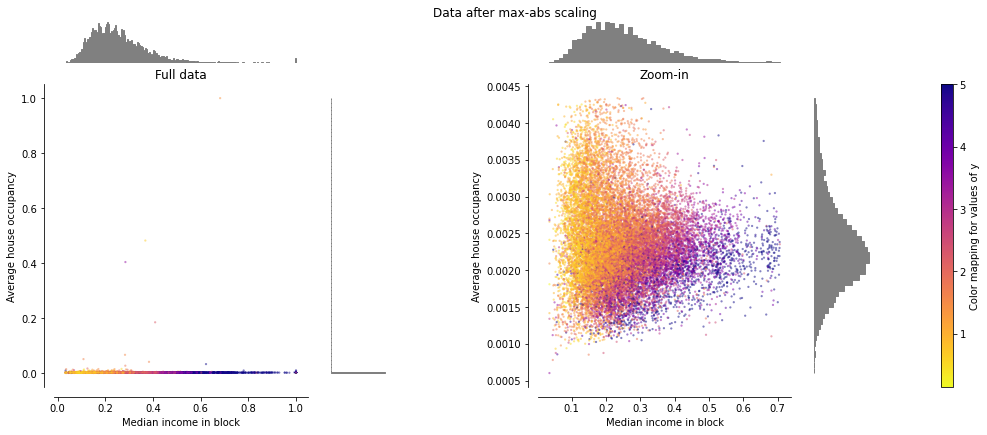

In [8]:
# MaxAbsScaler().fit_transform(X))
make_plot(3)

### RobustScaler 

RobustScaler는 Median 값과 Percentile을 기반으로 하기때문에 이상치에 대해서 민감하지 않습니다. 

두 Feature는 이전 Scaler에 비해 비슷한 범위([-2, 3])를 가지며 잘 변환됩니다. 

하지만, 데이터가 Skew 되어 있는 부분은 변환되지 않습니다.   

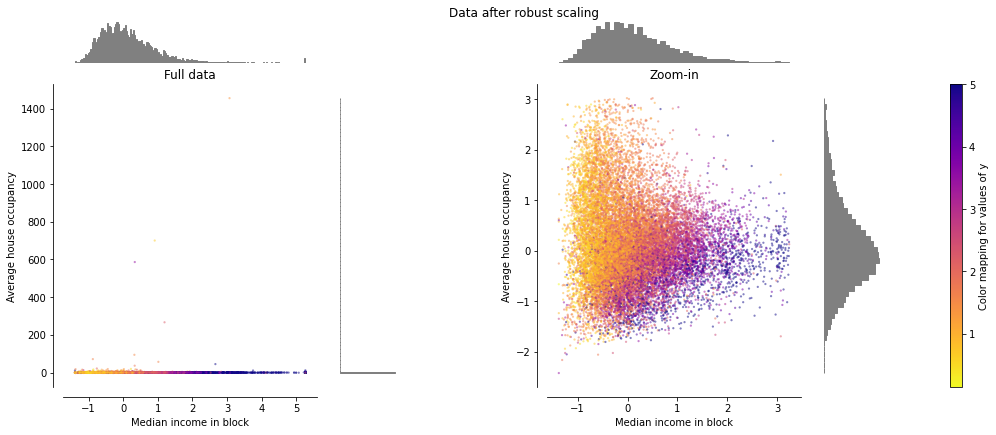

In [9]:
# RobustScaler(quantile_range=(25, 75)).fit_transform(X))
make_plot(4)

## Non-linear transformation
### PowerTransformer

PowerTransformer는 Feature의 범위 뿐 아니라 분포를 Gaussian 에 가깝도록 변환 합니다. 이에 이상치 뿐만 아니라 데이터의 Skew 에도 강건하게 됩니다.

PowerTransformer의 기본은 maximum likelihood estimation을 통한 variance 안정화와 skewness 최소화입니다. 

Yeo-Johnson 방법은 데이터에 음수가 존재할 경우, Box-Cox는 데이터에 양수만 존재할 경우 사용합니다.

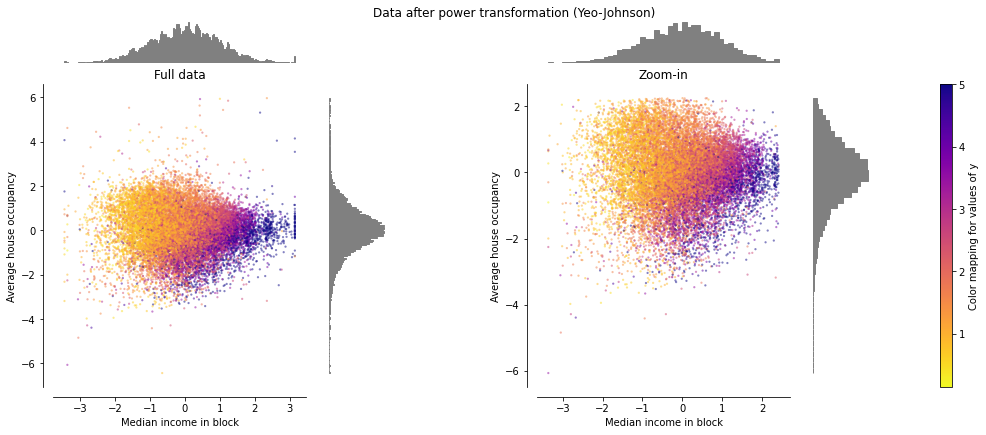

In [10]:
# PowerTransformer(method='yeo-johnson').fit_transform(X))
make_plot(5)

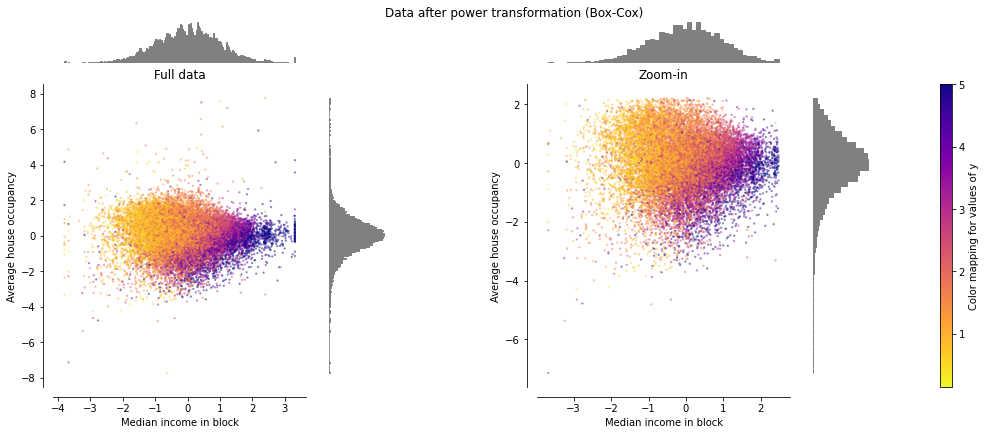

In [11]:
# PowerTransformer(method='box-cox').fit_transform(X))
make_plot(6)

### QuantileTransformer 

QuantileTransformer는 output_distribution 파라미터를 통해 출력 분포를 지정할 수 있습니다.

* normal: Gaussian 분포
* uniform: Uniform 분포, 모든 데이터는 범위 [0, 1]로 변환

이상치 및 데이터의 Skew 에 대해서도 강건합니다.

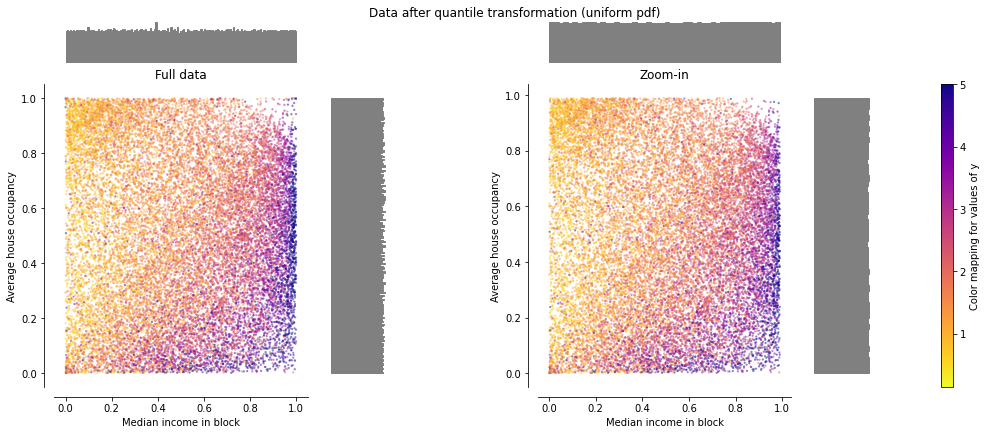

In [12]:
# QuantileTransformer(output_distribution='normal').fit_transform(X)
make_plot(7)

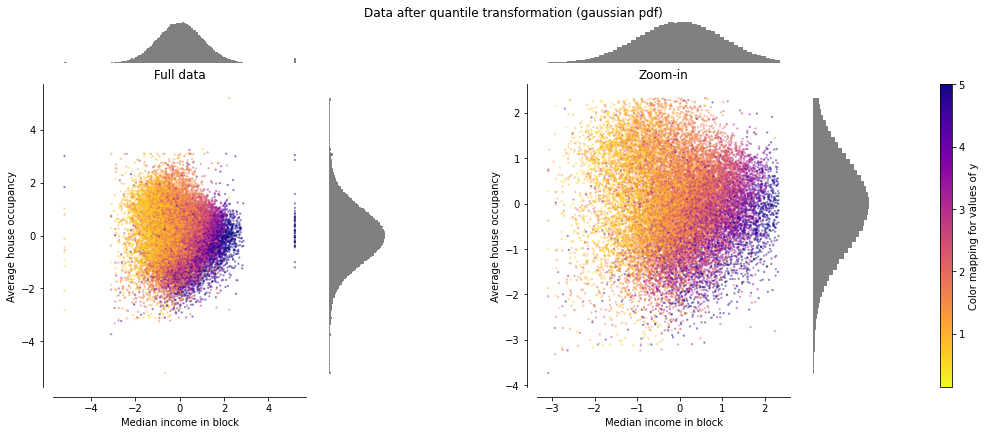

In [13]:
# QuantileTransformer(output_distribution='uniform').fit_transform(X)
make_plot(8)

## Normalization
### Normalizer

Unit Norm 을 가지도록 개별 샘플을 재조정합니다. 

이는 샘플 쌍의 유사성을 Matrix 의 곱이나 2차 함수를 통해 정량화하려는 경우 유용 할 수 있습니다. 

이는 텍스트 분류 및 클러스터링에서 자주 사용되는 벡터 공간 모델의 기본입니다.

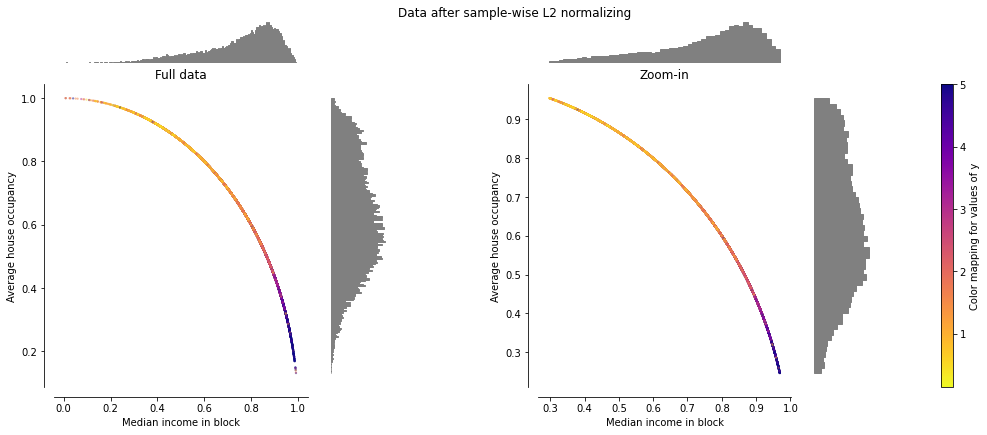

In [14]:
# Normalizer().fit_transform(X)
make_plot(9)

## Encoding categorical features

범주형으로 제공 된 Feature 또는 Label을 효율적으로 처리하기 위하여 정수로 부호화 합니다.

Feature 용
* OrdinalEncoder: 정수 (0 ~ n_categories - 1)형태로 변환
* OneHotEnconder: 이진 (0 or 1) 형태로 변환

Label 용
* LabelEncoder: 정수 (0 ~ n_categories - 1)형태로 변환
* LabelBinarizer: 이진 (0 or 1) 형태로 변환

### OrdinalEncoder

In [15]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox'], ['female', 'from Asia', 'uses Chrome']]
enc.fit(X)  
enc.transform([['female', 'from Asia', 'uses Safari']])

array([[0., 0., 2.]])

결과는 아래와 같이 각 Feature가 정수 형태로 변환되었습니다.

```
[[0.,      0.,      2.]]
  Gender,  Country, Browser
``` 

### OneHotEncoder

In [16]:
enc = preprocessing.OneHotEncoder()
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox'], ['female', 'from Asia', 'uses Chrome']]
enc.fit(X)  
enc.transform([['female', 'from US', 'uses Safari'], ['male', 'from Europe', 'uses Safari']]).toarray()

array([[1., 0., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0., 1.]])

결과는 아래와 같이 각 Feature가 이진 형태로 변환되었습니다.

```
[1., 0.,    0., 0., 1.,    0., 0., 1.]
 Gender     Country        Browser
```

### LabelEncoder

In [17]:
le = preprocessing.LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])
print("classes_: {}".format(le.classes_))

trans = le.transform(["tokyo", "tokyo", "paris"])
print("transform: {}".format(trans))
inv_trans = le.inverse_transform(trans)
print("inverse_transform: {}".format(inv_trans))

classes_: ['amsterdam' 'paris' 'tokyo']
transform: [2 2 1]
inverse_transform: ['tokyo' 'tokyo' 'paris']


### LabelBinarizer

In [18]:
le = preprocessing.LabelBinarizer()
le.fit(["paris", "paris", "tokyo", "amsterdam"])
print("classes_: {}".format(le.classes_))

trans = le.transform(["tokyo", "tokyo", "paris"])
print("transform: {}".format(trans))

inv_trans = le.inverse_transform(trans)
print("inverse_transform: {}".format(inv_trans))

classes_: ['amsterdam' 'paris' 'tokyo']
transform: [[0 0 1]
 [0 0 1]
 [0 1 0]]
inverse_transform: ['tokyo' 'tokyo' 'paris']


## Discretization

연속 피쳐를 정의된 범위의 값으로 분할하는 방법을 제공합니다.

### K-bins discretization

KBinsDiscretizer 는 Feature들을 K개의 균등한 빈으로 분할하여 이산화 합니다.

In [19]:
X = np.array([[ -3., 5., 15 ],
              [  0., 6., 14 ],
              [  6., 3., 11 ]])
est = preprocessing.KBinsDiscretizer(n_bins=[3, 2, 2], encode='ordinal').fit(X)
est.transform(X) 

array([[0., 1., 1.],
       [1., 1., 1.],
       [2., 0., 0.]])

n_bins=[3, 2, 2] 에서 각 피처는 아래와 같이 이산화 됩니다.

* feature 1: $[-\infty, -1), [-1, 2), [2, \infty)$
* feature 2: $[-\infty, 5), [5, \infty)$
* feature 3: $[-\infty, 14), [14, \infty)$


### Feature binarization

Feature binarization는 주어지 Threshold 값에 따라 Feature 를 Boolean 값으로 변환 합니다. 

In [20]:
X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]

binarizer = preprocessing.Binarizer().fit(X)  # fit does nothing
print(binarizer)

print(binarizer.transform(X))

binarizer = preprocessing.Binarizer(threshold=1.1).fit(X)  # fit does nothing
print(binarizer)

print(binarizer.transform(X))

Binarizer()
[[1. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Binarizer(threshold=1.1)
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]]


## Imputation of missing values

다양한 이융로 실세계 데이터에서는 결측치가 나타날 수 있습니다. Scikit-Learn의 모델은 결측치가 없다고 가정하기 때문에 모델 입력전에 제거 또는 대체가 필요합니다.

### Univariate feature imputation

결측치를 대치하기 위한 기본 전략을 제공합니다. 대치 방식으로는 평균값, 중앙값, 최빈값 등을 선택할 수 있습니다.

In [21]:
from sklearn import impute

train_xs = [[1, 2], [np.nan, 3], [7, 6]]
print(f"train_xs\n{train_xs}")

# strategy: mean, median, most_frequent, constant
imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
train_xs = imp.fit_transform(train_xs)
print(f"transformed train_xs\n{train_xs}")

test_xs = [[np.nan, 2], [6, np.nan], [7, 6]]
print(f"test_xs\n{test_xs}")

test_xs = imp.transform(test_xs)
print(f"transformed test_xs\n{test_xs}")

train_xs
[[1, 2], [nan, 3], [7, 6]]
transformed train_xs
[[1. 2.]
 [4. 3.]
 [7. 6.]]
test_xs
[[nan, 2], [6, nan], [7, 6]]
transformed test_xs
[[4.         2.        ]
 [6.         3.66666667]
 [7.         6.        ]]


### Multivariate feature imputation

결측치를 대치하기 위해 좀 더 정교한 모델을 이용한 전략을 제공합니다. 기본적인 대치 방식으로는 선형 모델을 사용합니다.

In [28]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa

train_xs = [[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]]
print(f"train_xs\n{train_xs}")

imp = impute.IterativeImputer(max_iter=10, random_state=0)
train_xs = imp.fit_transform(train_xs)
print(f"transformed train_xs\n{train_xs}")

test_xs = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
print(f"test_xs\n{test_xs}")

test_xs = imp.transform(test_xs)
print(f"transformed test_xs\n{test_xs}")

train_xs
[[1, 2], [3, 6], [4, 8], [nan, 3], [7, nan]]
transformed train_xs
[[ 1.          2.        ]
 [ 3.          6.        ]
 [ 4.          8.        ]
 [ 1.50004509  3.        ]
 [ 7.         14.00004135]]
test_xs
[[nan, 2], [6, nan], [nan, 6]]
transformed test_xs
[[ 1.00007297  2.        ]
 [ 6.         12.00002754]
 [ 2.99996145  6.        ]]


대치 방식으로는 기본적인 선형 모델 외에 Scikit-learn에서 제공하는 모델 클래스들과 결합하여 다양한 전략으로 결측치를 처리하는 것이 가능합니다.

* BayesianRidge: regularized linear regression
* DecisionTreeRegressor: non-linear regression
* ExtraTreesRegressor: similar to missForest in R
* KNeighborsRegressor: comparable to other KNN imputation approaches

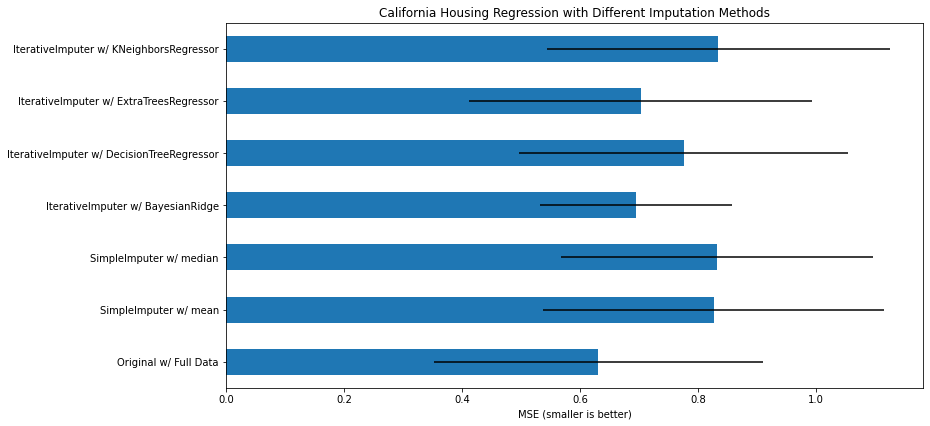

In [29]:
# https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py
import warnings 
warnings.filterwarnings(action='ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features="sqrt", random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator), br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("California Housing Regression with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

### Nearest neighbors imputation

KNNImputer는 k-최근접 이웃 접근 방식을 사용하여 샘플 중에서 선택된 값으로 결측값 대치합니다. 

위 예제에서 다룬 KNeighborsRegressor와 IterativeImputer를 이용한 방법은 모델을 통해 결측값을 예측하고 대치하는 방식으로 KNNImputer와는 다릅니다.

In [30]:

train_xs = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]
print(f"train_xs\n{train_xs}")

imp = impute.KNNImputer(n_neighbors=2, weights="uniform")
train_xs = imp.fit_transform(train_xs)
print(f"transformed train_xs\n{train_xs}")

train_xs
[[1, 2, nan], [3, 4, 3], [nan, 6, 5], [8, 8, 7]]
transformed train_xs
[[1.  2.  4. ]
 [3.  4.  3. ]
 [5.5 6.  5. ]
 [8.  8.  7. ]]


## Generating polynomial features

데이터의 Feature를 고차원으로 퍼트려 설명력을 증가 시키기 위해 사용됩니다. 아래에서는 차원을 올리는 것과 interaction 만을 증가시키는 예제를 볼 수 있습니다.

In [22]:
X = np.arange(6).reshape(3, 2)
print(X)

# (X1, X2) => (1, X1, X2, X1^2, X1*X2, X2^2)
poly = preprocessing.PolynomialFeatures(2)
print(poly.fit_transform(X))

# (X1, X2) => (1, X1, X2, X1*X2)
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=True)
print(poly.fit_transform(X))

[[0 1]
 [2 3]
 [4 5]]
[[ 1.  0.  1.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.]
 [ 1.  4.  5. 16. 20. 25.]]
[[ 1.  0.  1.  0.]
 [ 1.  2.  3.  6.]
 [ 1.  4.  5. 20.]]
